In [2]:
!pip install pylatex

In [ ]:
plt.close()

In [3]:
import os
import uuid
import shutil
import pylatex
import pandas as pd
import lightkurve as lk 
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm.notebook import tqdm
from multiprocessing import cpu_count, Pool
from pylatex.section import Chapter, Subsection
from pylatex import Document, Section, Figure, SubFigure, NoEscape, Command

plt.ioff()
%run pipeline.ipynb

OUTPUT_PATH = "/home/jovyan/SRMP-JMAG/output"

In [4]:
def get_sectors(tic):
    """Returns a list of available sectors given an TIC."""
    sectors = []
    for result in lk.search_tesscut(str(tic)):
        sectors.append(int(result.mission[0].split(" ")[2]))
        
    return {"tic": tic, "sectors": sectors}

def get_targets(tics):
    """Constructs a dictionary of TICs and available sectors from a list of TICs"""
    targets = []
    with Pool(cpu
    with tqdm(total=len(tics)) as pbar:
        for tic in tics:
            targets.append(get_sectors(tic))
            pbar.update()
    return targets
                
targets = get_targets(pd.read_csv("./stars.csv")["TIC"])


  0%|          | 0/34 [00:00<?, ?it/s]

In [5]:
complex = {}
not_complex = {}

# This first loop will populate the list of complex and non-complex stars
for target in targets:
    for sector in target["sectors"]:
        if sector <= 56: # FFIs are only high enough res after sector 5.
            continue
        lc = load_lc(f"{target['tic']}", sector)
            
        # Determine complexity
        if complexitycheck(lc):
            if target["tic"] not in complex.keys():
                complex[target["tic"]] = []
            complex[target["tic"]].append(sector)
        else:
            if target["tic"] not in not_complex.keys():
                not_complex[target["tic"]] = []
            not_complex[target["tic"]].append(sector)
        if not os.path.isdir(f"{OUTPUT_PATH}/{target['tic']}"):
            os.mkdir(f"{OUTPUT_PATH}/{target['tic']}")

        # Plot river and save
        plt.figure(river_plot(lc).number) # this is necessary to make the output current and save the correct figure.
        plt.savefig(f"{OUTPUT_PATH}/{target['tic']}/{sector}_river.png")
        plt.close()

        # Plot lc and save
        plt.figure(graph_lc(lc).number) 
        plt.savefig(f"{OUTPUT_PATH}/{target['tic']}/{sector}_plot.png")
        plt.close()

        # Lombscargle lc and save
        plt.figure(lombscargle(lc).number) 
        plt.savefig(f"{OUTPUT_PATH}/{target['tic']}/{sector}_periodogram.png")
        plt.close()


        # TODO: Periodogram when fixed.

In [7]:
def make_dataframes(l):
    
    df = pd.DataFrame()
    
    tics = []
    sectors = []
    for tic in list(l.keys()):
        for sector in l[tic]:
            tics.append(tic)
            sectors.append(sector)
    
    df["TIC"] = tics
    df["Sectors"] = sectors

    return df

make_dataframes(complex).to_csv(f"{OUTPUT_PATH}/complex.csv")
make_dataframes(not_complex).to_csv(f"{OUTPUT_PATH}/not_complex.csv")

In [26]:
def make_chapter(title, data, doc):
    with doc.create(Chapter(title)):
        for tic in data.keys():
            doc.append(NoEscape(r'\newpage'))
            with doc.create(Section(f"{tic}")):
                for i, sector in enumerate(data[tic]):
                    if i > 0:
                        doc.append(NoEscape(r'\newpage'))
                    with doc.create(Subsection(f"Sector {sector}", label=f"{tic}_{sector}")):
                        lc = load_lc(f"{tic}", sector)
                        
                        plt.figure(river_plot(lc).number)
                        with doc.create(Figure(position='H')) as plot:
                            doc.append(NoEscape(r'\begin{center}'))
                            plot.add_plot(width=NoEscape(r'0.5\textwidth'))
                            doc.append(NoEscape(r'\end{center}'))
                        plt.close()

                        plt.figure(graph_lc(lc).number)
                        with doc.create(Figure(position='H')) as plot:
                            doc.append(NoEscape(r'\begin{center}'))
                            plot.add_plot(width=NoEscape(r'0.5\textwidth'))
                            doc.append(NoEscape(r'\end{center}'))
                        plt.close()

                        plt.figure(lombscargle(lc).number)
                        with doc.create(Figure(position='H')) as plot:
                            doc.append(NoEscape(r'\begin{center}'))
                            plot.add_plot(width=NoEscape(r'0.5\textwidth'))
                            doc.append(NoEscape(r'\end{center}'))
                        plt.close()

def make_pdf_report():
    try:
        shutil.rmtree("./build")
    except:
        pass
    os.mkdir("./build")

    doc = Document(documentclass="report", lmodern=False, geometry_options={"margin": "0.5in", "top": "0.5in", "bottom": "0.5in"})

    doc.preamble.append(Command("title", "JMAG Complex Rotator Pipeline Results"))
    doc.preamble.append(Command("date", f"Generated on {datetime.now().strftime('%x %X')}"))
    doc.preamble.append(NoEscape(r'\usepackage{float}'))
    doc.preamble.append(NoEscape(r'\usepackage{hyperref}'))
    doc.preamble.append(NoEscape(r'\hypersetup{colorlinks=true}'))


    doc.append(NoEscape(r'\maketitle'))
    doc.append(NoEscape(r'\tableofcontents'))
    
    make_chapter("Complex Rotators", complex, doc)
    make_chapter("Non-Complex Rotators", not_complex, doc)
    doc.generate_tex("./build/main")
    
    os.system("cd build && pdflatex -interaction=nonstopmode main.tex && pdflatex -interaction=nonstopmode main.tex")
    
make_pdf_report()

In [ ]:
import threading

doc = Document(documentclass="report", lmodern=False, geometry_options={"margin": "0.5in", "top": "0.5in", "bottom": "0.5in"})

doc.preamble.append(Command("title", "JMAG/SPOC Comparisons"))
doc.preamble.append(Command("date", f"Generated on {datetime.now().strftime('%x %X')}"))

threads = []
progress_bars = {}

for tic in tqdm(complex.keys(), desc="Processing Tickers", unit="ticker"):
    progress_bars[tic] = tqdm(total=len(complex[tic]), desc=f"Processing {tic}", leave=False)
    thread = threading.Thread(target=process_sector, args=(tic,))
    threads.append(thread)
    thread.start()

def process_sector(tic):
    for sector in complex[tic]:
        try:
            with doc.create(Figure(position='h!')) as figure:
                with doc.create(SubFigure(position="b", width=NoEscape(r'0.45\linewidth'))) as plot:
                    result = lk.search_lightcurve(tic, sector=sector)[0]
                    lc = result.download()
                    lcplot = graph_lc(lc, title=f"{tic} Sector {sector} -- {result.author.data[0]} {str(int(result.exptime.value[0]))}s Cadence")
                    plt.figure(lcplot.number)
                    plot.add_plot(width=NoEscape(r'\linewidth'))
                with doc.create(SubFigure(position="b", width=NoEscape(r'0.45\linewidth'))) as image:
                    image.add_image(f"./output/{tic}/{sector}_plot.png", width=NoEscape(r'\linewidth'))
        except:
            print(f"Could not compare {tic} sector #{sector}")
        finally:
            progress_bars[tic].update(1)
        plt.close("all")
    progress_bars[tic].close()

for tic in complex.keys():
    thread = threading.Thread(target=process_sector, args=(tic,))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

doc.generate_tex("./build/comparison")

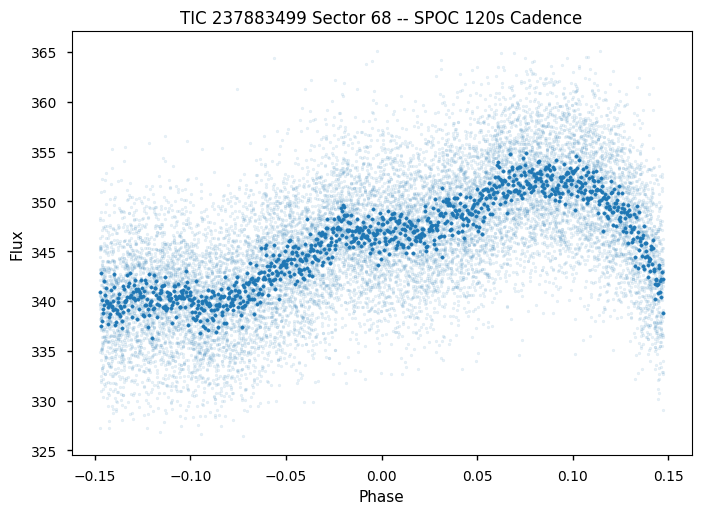

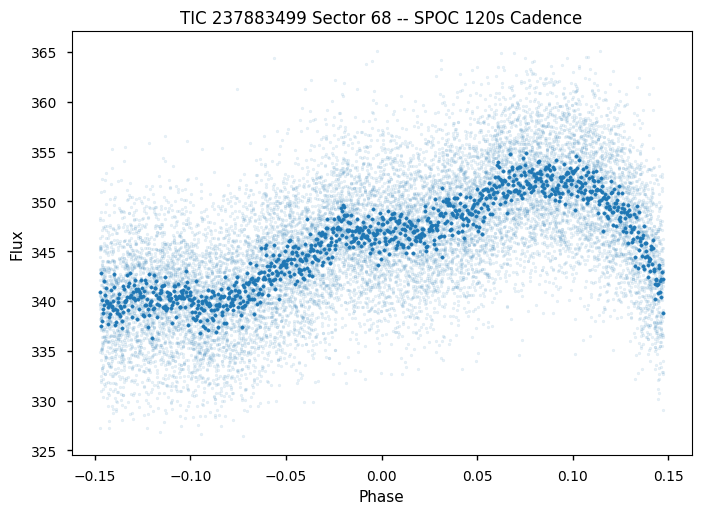

In [78]:
result = lk.search_lightcurve(tic, sector=sector)[0]
lc = result.download()
graph_lc(lc, title=f"{tic} Sector {sector} -- {result.author.data[0]} {str(int(result.exptime.value[0]))}s Cadence")

In [43]:
tic = "TIC 237883499"
sector = 68